In [1]:
import rebound
import matplotlib.pyplot as plt
import ctypes
photlib = ctypes.CDLL("./c_src/cwrapper.so")

import astropy.constants as ac
strad = ac.au.value / ac.R_sun.value

In [2]:
def get_impact_parameters(sim, t):
    xp = np.zeros(len(t))
    zp = np.zeros(len(t))
    xm = np.zeros(len(t))
    zm = np.zeros(len(t))

    for i in range(len(t)):
        sim.integrate(t[i])
        xp[i] = sim.particles[1].x * strad
        zp[i] = sim.particles[1].z * strad
        xm[i] = sim.particles[2].x * strad
        zm[i] = sim.particles[2].z * strad
    
    bp2 = xp*xp + zp*zp
    bm2 = xm*xm + zm*zm
    bpm2 = (xp-xm)**2 + (zp-zm)**2
    return bp2, bm2, bpm2

CPU times: user 1.04 s, sys: 24.9 ms, total: 1.06 s
Wall time: 1.16 s


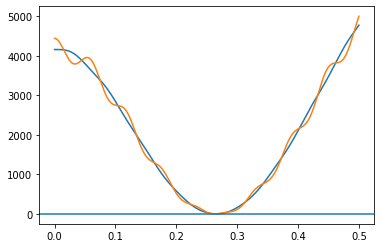

In [3]:
t = np.linspace(0, 0.5, 50000)

sim = rebound.Simulation()

sim.add(m=1.)                # Central object
sim.add(m=1e-2, a=0.3, e=0.0) # Jupiter mass planet 
sim.add(primary=sim.particles[1], m = 1e-3, a=0.01, e=0.0, inc=0.1)        # Massless test particle

sim.integrator = "whfast"
sim.dt = 0.1

%time bp2, bm2, bpm2 = get_impact_parameters(sim, t)
plt.plot(t, bp2)
plt.plot(t, bm2)
#plt.plot(t, bpm2)
plt.axhline(1.0)
#plt.ylim(-1, 1)
#plt.xlim(0.2, 0.3)
#plt.xlim(5.5, 6.5)

In [4]:
def flux(c1, c2, rp, rm, bp2, bm2, bpm2):
    
    if not hasattr(bp2, "__len__"):
        bp2 = np.array([bp2])
    if not hasattr(bm2, "__len__"):
        bm2 = np.array([bm2])
    if not hasattr(bpm2, "__len__"):
        bpm2 = np.array([bpm2])
    
    bp2 = (ctypes.c_double * len(bp2)).from_buffer(bp2)
    bm2 = (ctypes.c_double * len(bm2)).from_buffer(bp2)
    bpm2 = (ctypes.c_double * len(bp2)).from_buffer(bp2)
    lc = (ctypes.c_double * len(bp2)).from_buffer(np.zeros(len(bp2)))
    rp = ctypes.c_double(rp)
    rm = ctypes.c_double(rm)
    c1 = ctypes.c_double(c1)
    c2 = ctypes.c_double(c2)
    j = ctypes.c_int(len(bp2))
    photlib.LC.restype = None
    photlib.LC(c1, c2, rp, rm, bp2, bm2, bpm2, lc, j)
    return np.array(lc)

def area(c1, c2, r, b, e):
    
    c1 = ctypes.c_double(c1)
    c2 = ctypes.c_double(c2)
    r = ctypes.c_double(r)
    b = ctypes.c_double(b)
    e = ctypes.c_double(e)
    
    photlib.Area.restype = ctypes.c_double
    res = photlib.Area(c1, c2, r, b, e)
    return res

In [ ]:
b = np.linspace(0, 0.89, 100)
A = [area(0.5, 0.5, 0.1, b, 1.0) for b in b]
plt.plot(b, A)

In [ ]:
from scipy.integrate import dblquad

def numerical_area(c1, c2, r, b):
    
    I = lambda x, y: 1 - c1 * (1 - np.sqrt(1 - x**2 - y**2)) - c2 * (1 - np.sqrt(1 - x**2 - y**2))**2
    lim1 = b - r
    lim2 = b + r
    gfun = lambda x: -np.sqrt(r**2 - (x - b)**2)
    hfun = lambda x: np.sqrt(r**2 - (x - b)**2)
    return dblquad(I, lim1, lim2, gfun, hfun)

In [ ]:
numerical_area(0.1, 0.2, 1.0, 0.0)

In [ ]:
area(0.1, 0.2, 0.01, 0.9, 1.0)

In [ ]:
b = np.linspace(0, 0.69, 100)
A = [numerical_area(0.3, 0.6, 0.3, b)[0] for b in b]
plt.plot(b, A)

b = np.linspace(0, 0.69, 100)
A = [area(0.3, 0.6, 0.3, b, 1.0) for b in b]
plt.plot(b, A)
#plt.ylim(0, 0.1)

CPU times: user 2.51 ms, sys: 880 µs, total: 3.39 ms
Wall time: 2.37 ms


(0.26, 0.27)

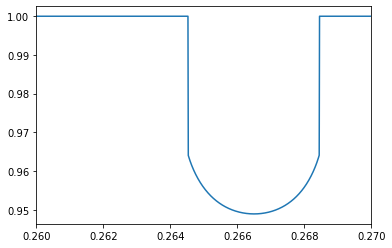

In [5]:
rp = 0.2
rm = 0.0
%time lc = flux(0.5, 0.5, rp, rm, bp2, bm2, bpm2)
plt.plot(t, lc, '-')
#plt.ylim(-1.01, -0.9)
plt.xlim(0.26, 0.27)

In [7]:
1 - 0.2 ** 2

0.96

In [ ]:
(1 - c1 - 2 * c2) * (np.pi) + (c1 + 2 * c2) * (2 * np.pi / 3) + c2 * (np.pi / 2)

In [ ]:
c1 = 0.1
c2 = 0.2
(1 - c1 - 2 * c2) * (np.pi) + (c1 + 2 * c2) * (2 * np.pi / 3) + c2 * (np.pi / 2)

In [ ]:
(1 - 0.2 ** 2)

In [ ]:
np.pi * 0.9999